Different Scoring mechanisms for Classification:


Learning Objectives:

- Multiclass Classification
- Scoring for Classification
- Heat Maps


https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients

The data have been organized in two different but related classification tasks.

column_3C_weka.csv (file with three class labels)

The first task consists in classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients).

column_2C_weka.csv (file with two class labels)

For the second task, the categories Disk Hernia and Spondylolisthesis were merged into a single category labelled as 'abnormal'. Thus, the second task consists in classifying patients as belonging to one out of two categories: Normal (100 patients) or Abnormal (210 patients).
Content

Field Descriptions:

Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (each one is a column):

pelvic incidence
pelvic tilt
lumbar lordosis angle
sacral slope
pelvic radius
grade of spondylolisthesis

Acknowledgements

The original dataset was downloaded from UCI ML repository:

Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

Files were converted to CSV

Inspiration

Use these biomechanical features to classify patients according to their labels

In [1]:
def readDataWith2Classes():
    import pandas as pd
    df = pd.read_csv('column_2C_weka.csv')
    y_ortho = df['class'].apply(lambda x: 1 if x in 'Abnormal' else 0)
    X_ortho = df.drop(df.columns[[6]],axis=1)
    return(X_ortho,y_ortho)
    

In [2]:
def readDataWith3Classes():
    import pandas as pd
    df = pd.read_csv('column_3C_weka.csv')
    classes = {"Normal": 0, "Spondylolisthesis" : 1, "Hernia": 2}
    y_ortho = df['class'].apply(lambda x:classes.get(x))
    X_ortho = df.drop(df.columns[[6]],axis=1)
    return(X_ortho,y_ortho)

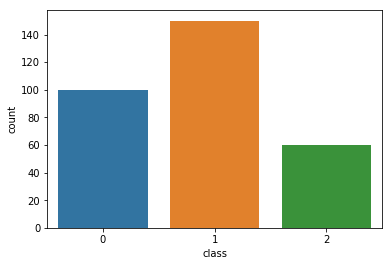

In [9]:
def plotCounts():
    import seaborn as sns
    %matplotlib inline
    
    (X,y) = readDataWith3Classes()
    sns.countplot(y,label="Count")
    
plotCounts()

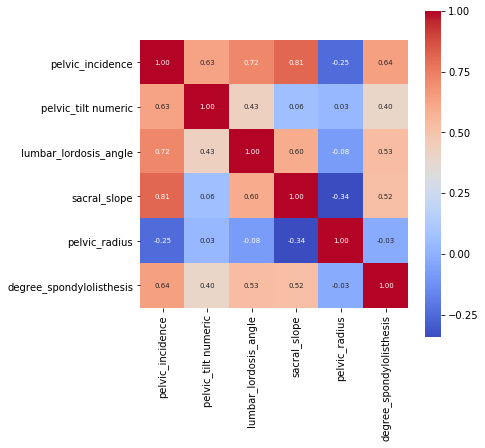

In [5]:
# the following is useful to see if features are correlated
# 1 is that they are totally correlated, 0 is that they are not correlated at all, 
# -1 is that they are negatively correlated (one is the opposite of the other)
# in this case they are moderately correlated so you can keep all the features
# if features are highly correlated (close to 1), you can remove a feature without 
# affecting the score
# e.g if calculating the price of a house and one feature is 'number of bedrooms', and the other
# feature is 'twice the number of bedrooms' they are correlated and the second doesn't add any
# extra information so it should be removed
def plotHeatMap():
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    #because we are not looking at y we can read either Data2Class or Data3Class
    (X,y) = readDataWith2Classes()
    corr = X.corr()
    plt.figure(figsize=(6,6))
    sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 7},
           xticklabels= X.columns, yticklabels= X.columns,
           cmap= 'coolwarm')
    plt.show()

plotHeatMap()

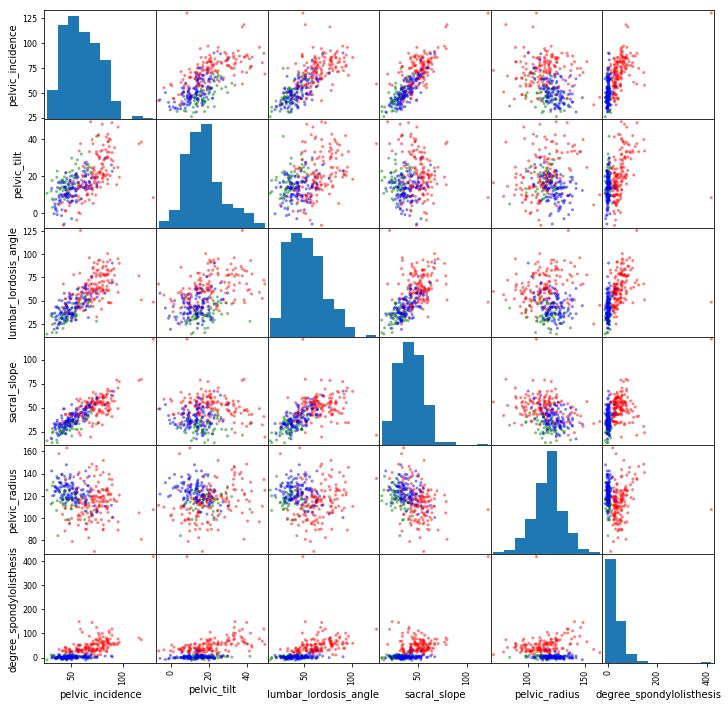

In [11]:
# it's a good idea to remove features that are not separatable
# in the following graph we can see that features 1, 2 and 3 cannot be separated for either class2 or class3
# %matplotlib inline is used to automatically plot without calling plt.show()
def plotRelationships():
    
    import pandas as pd
    from pandas.plotting import scatter_matrix
    import matplotlib.pyplot as plt
    
    (X,y) = readDataWith3Classes()
    color_function = {0: "blue", 1: "red", 2: "green"}
    colors = y.map(lambda x: color_function.get(x))
    scatter_matrix(X, c=colors, alpha = 0.5, figsize = (12, 12), diagonal='hist')
    plt.show()
    
plotRelationships()

In [26]:
# use a decision tree classifier for the data with only two classes, 
# use a depth = 2 to see which features are more prominently used (the higher the number, the most weight that
# feature has)
# change the depth from 1 to 4 to see how that changes
# as you can see the decision tree agrees with the plot of relationships where the most weight is on the
# last two features: 'pelvic_radius' and 'degree_spondylolisthesis'
def getDecisionTree():
    
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    
    scaler = MinMaxScaler()
    (X,y) = readDataWith2Classes()
    depth = 2
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       random_state = 0)
    # both training set and testing set need to be scaled
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    tree = DecisionTreeClassifier(max_depth=depth,random_state=0).fit(X_train_scaled, y_train)
    print(tree.feature_importances_)
    print(X.columns)
    return (tree.score(X_train_scaled, y_train),tree.score(X_test_scaled, y_test))

getDecisionTree()

[ 0.          0.          0.          0.          0.23276182  0.76723818]
Index(['pelvic_incidence', 'pelvic_tilt numeric', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis'],
      dtype='object')


(0.85775862068965514, 0.75641025641025639)

In [27]:
# remove columns [0],[1],[2],[3], [0, 1], [0, 2], [1, 2], and [0,1,2] to see which one gives you the best match
# compare it if you leave all columns in
# which one do you think is the best? what happens when you take out [3]
# use the best one you found for the next three exercises
# 
def SVCGrid():
    
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    
    scaler = MinMaxScaler()
    (X,y) = readDataWith2Classes()
    
    # if you want to include all columns just do    X_clean = X
    X_clean = X.drop(X.columns[[0,1,2]],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y,
                                                       random_state = 0)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,20,50]}
    clf = GridSearchCV(SVC(), parameters)
    
    # both training set and testing set need to be scaled
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf.fit(X_train_scaled,y_train)
    svc = clf.best_estimator_.fit(X_train_scaled,y_train)
    print(svc)
    return (svc.score(X_train_scaled, y_train),svc.score(X_test_scaled, y_test))

SVCGrid()

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


(0.875, 0.83333333333333337)

In [22]:
# common scoring in Classification:
# accuracy: (true pos + true neg)/(true pos + false pos + true neg + false neg) //this is the usual default
# precision: (true pos)/(true pos + false pos) // high precision: minimize false positives
# e.g. a spam filter needs high precision, so not to flag emails as spam if they are not
# 
# recall: (true pos)/(true pos + false neg) // high recall: minimize false neg
# A credit fraud detector needs high recall, so not to let any fraud get through
# 
# f1: F1 = 2 * (precision * recall) / (precision + recall)  //when both precision and recall are important
# 
# roc_auc: Area Under the Receiver Operating Characteristic Curve 
# roc_auc is used specially for highly unbalanced datasets (one class occurs much more often than the other)
# 
# In this example, what would high precision be? how about high recall? which one do you think
# the model should try to maximize in this example
# run this example with 'precision' and 'recall' as scoring, which one gives you the best overall score
# clf = GridSearchCV(SVC(), parameters,scoring='recall')
def SVCGridWithScoring():
    
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    
    scaler = MinMaxScaler()
    (X,y) = readDataWith2Classes()
    
    # if you want to include all columns just do    X_clean = X
    X_clean = X.drop(X.columns[[1]],axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y,
                                                       random_state = 0)
    parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,20,50]}
    clf = GridSearchCV(SVC(), parameters,scoring='precision')
    
    # both training set and testing set need to be scaled
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    clf.fit(X_train_scaled,y_train)
    svc = clf.best_estimator_.fit(X_train_scaled,y_train)
    print(svc)
    return (svc.score(X_train_scaled, y_train),svc.score(X_test_scaled, y_test))

SVCGridWithScoring()

SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


(0.87068965517241381, 0.80769230769230771)

In [ ]:
# use a NeuralNetwork and a RandomForest to find your model
#  which ones gives you a better approximation?
def getNeuralNetwork()



getNeuralNetwork()

In [ ]:
# use a NeuralNetwork and a RandomForest to find your model
#  which ones gives you a better approximation?
def getRandomForest()



getRandomForest()